<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block> 
        <font size=3>Homework 3</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
    </div>
</div>

# **Part1: Diffusion Models and Latent Diffusion**



In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  9 22:50:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8              15W / 130W |    630MiB /  6144MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
Overview of different types of generative models. (from [this great blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains. 
- Train a model to 'undo' these noise steps. 
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image. 

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One



In [2]:
# @title Install requirements
!pip install datasets &>> install.log

The syntax of the command is incorrect.


In [3]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

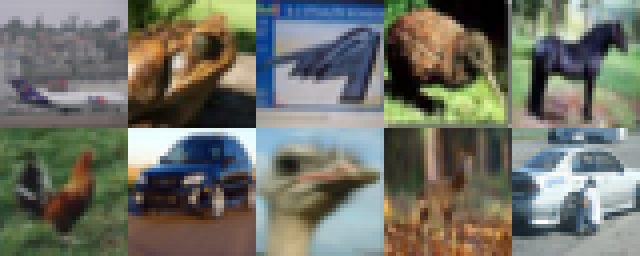

In [4]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [5]:
# @title alternative dataset: faces (CelebA) - uncomment to run 
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

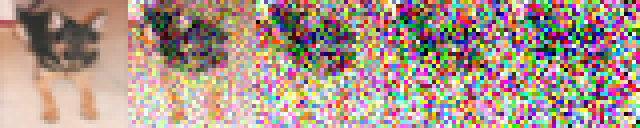

In [6]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate noise
    
    epsilon = torch.randn_like(xtm1)
    
    mean = gather(1 - beta, t) ** 0.5 * xtm1
    var = gather(beta, t)
    
    return mean + (var ** 0.5) * epsilon
    
    # End 
    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))
  
  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37. 

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$. 

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


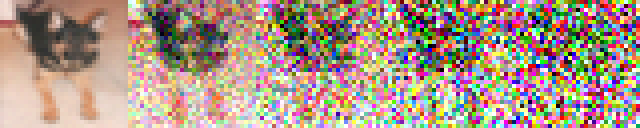

In [7]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  ################################################################################
    # TODO: complete the code here
    # Complete this function using the equation above to generate the appropriate noise

    epsilon = torch.randn_like(x0)
    
    mean = gather(alpha_bar, t) ** 0.5 * x0
    var = 1 - gather(alpha_bar, t)
    
    return mean + (var ** 0.5) * epsilon

    # End 
    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

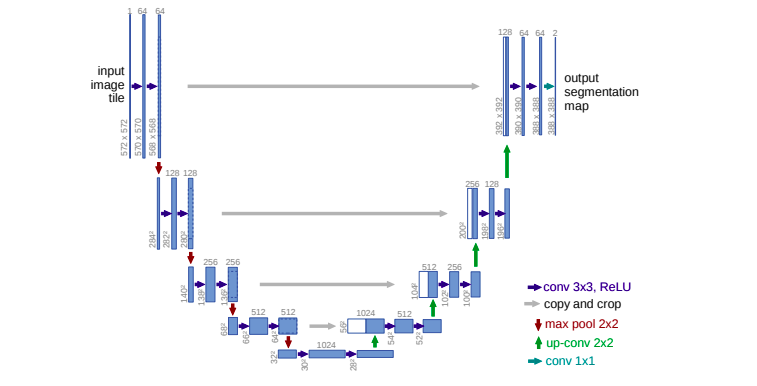

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers. 

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks. 

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [8]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding 
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [9]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [10]:
# Create the model
unet = UNet(n_channels=32).cuda()

# Set up some parameters
n_steps = 1000
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
################################################################################
    # TODO: complete the code here
    # Write the equation that you have witen in the previous section here again
    # This time write it based on what you want from it in the training process

    epsilon = torch.randn_like(x0).to(x0.device)
    
    mean = gather(alpha_bar, t) ** 0.5 * x0
    var = 1 - gather(alpha_bar, t)
    
    return mean + (var ** 0.5) * epsilon, epsilon

    # End 
################################################################################

# Training params
batch_size = 128 # Lower this if hitting memory issues
lr = 5e-5 # Explore this - might want it lower when training on the full dataset

losses_iteration = {"train": [], "val": []} # Store losses for later plotting
losses_epoch = {"train": [], "val": []} # Store losses for later plotting



################################################################################
    # TODO: complete the code here
    # Define the relevant Optimizer to train your model

optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer
    
    # End 
################################################################################



In [11]:
# Training Loop

################################################################################
    # TODO: complete the code here
    # Write the main and forward training loop here

device = "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(60):
    unet.train()

    train_loss = 0
    val_loss= 0

    counter_train = 0
    counter_val = 0
    
    for i in tqdm(range(0, len(cifar10["train"]) - batch_size, batch_size)):
        images = [cifar10["train"][j]["img"] for j in range(i, i + batch_size)]
        images = [img_to_tensor(image).to(device) for image in images]
        x0 = torch.cat(images)
        
        t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
        
        xt, noise = q_xt_x0(x0, t)
        
        output = unet(xt.float(), t)
        
        loss = F.mse_loss(noise.float(), output)
        losses_iteration["train"].append(loss.item())
        train_loss += loss.item()
        
        optim.zero_grad()
        loss.backward()
        optim.step()

        counter_train += 1

    unet.eval()

    with torch.no_grad():
        for j in tqdm(range(0, len(cifar10["test"])-batch_size, batch_size)):
            images = [cifar10["test"][j]["img"] for k in range(j, j + batch_size)]
            images = [img_to_tensor(image).to(device) for image in images]
            x0 = torch.cat(images)
            
            t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).to(device)
            
            xt, noise = q_xt_x0(x0, t)
            
            output = unet(xt.float(), t)
            
            loss = F.mse_loss(output, noise.float())
            losses_iteration["val"].append(loss.item())
            val_loss += loss.item()

            counter_val += 1

    train_loss = train_loss / counter_train
    val_loss = val_loss / counter_val
    
    losses_epoch["train"].append(train_loss)
    losses_epoch["val"].append(val_loss)

    print(f"EPOCH: {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}\n")
    
    # End 
################################################################################

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 1, Training Loss: 0.2896041844708797, Validation Loss: 0.12084207530969228



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 2, Training Loss: 0.09449884518025778, Validation Loss: 0.07196626296410194



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 3, Training Loss: 0.06349161055225593, Validation Loss: 0.05652329464180347



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 4, Training Loss: 0.05182459173389734, Validation Loss: 0.047965280448970124



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 5, Training Loss: 0.04501993829527726, Validation Loss: 0.04274831342104918



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 6, Training Loss: 0.041335047399386385, Validation Loss: 0.039921583177951664



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 7, Training Loss: 0.03937258104292246, Validation Loss: 0.03719148655923513



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 8, Training Loss: 0.03705941662669946, Validation Loss: 0.03529105185029598



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 9, Training Loss: 0.03530391575052188, Validation Loss: 0.03374684093376765



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 10, Training Loss: 0.03398635762337691, Validation Loss: 0.03139766201806756



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 11, Training Loss: 0.032625379585302795, Validation Loss: 0.03078720284005006



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 12, Training Loss: 0.03192720872660478, Validation Loss: 0.03214759441713492



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 13, Training Loss: 0.03148630189781006, Validation Loss: 0.03055312097645723



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 14, Training Loss: 0.03027777087229949, Validation Loss: 0.030694024326900642



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 15, Training Loss: 0.030184843056859114, Validation Loss: 0.029203996396599673



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 16, Training Loss: 0.02945011502895982, Validation Loss: 0.029468341832025312



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 17, Training Loss: 0.028974410683776323, Validation Loss: 0.029100211432729013



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 18, Training Loss: 0.02834174420254735, Validation Loss: 0.02834210670194947



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 19, Training Loss: 0.02891830449255231, Validation Loss: 0.028328937167922657



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 20, Training Loss: 0.02839582370928465, Validation Loss: 0.028498831025969524



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 21, Training Loss: 0.028288595261386572, Validation Loss: 0.02712614877292743



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 22, Training Loss: 0.02801628181567559, Validation Loss: 0.026631358867654435



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 23, Training Loss: 0.026912006738189703, Validation Loss: 0.02779189050078201



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 24, Training Loss: 0.0277378562073677, Validation Loss: 0.02641429813005603



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 25, Training Loss: 0.02752504042373636, Validation Loss: 0.026359418550362952



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 26, Training Loss: 0.026987144685326477, Validation Loss: 0.02701380716350216



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 27, Training Loss: 0.02723472739975804, Validation Loss: 0.027462895398434155



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 28, Training Loss: 0.02712615124690227, Validation Loss: 0.02679079581195345



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 29, Training Loss: 0.02662720404422054, Validation Loss: 0.02590365417731496



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 30, Training Loss: 0.026326975336250585, Validation Loss: 0.02602235694678548



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 31, Training Loss: 0.02685004226767864, Validation Loss: 0.02674818781610483



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 32, Training Loss: 0.02668771894696431, Validation Loss: 0.026184671713660162



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 33, Training Loss: 0.026408945831159752, Validation Loss: 0.02626895632308263



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 34, Training Loss: 0.025676808611322672, Validation Loss: 0.024674348377933104



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 35, Training Loss: 0.02576859157341413, Validation Loss: 0.024972712083791312



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 36, Training Loss: 0.026325134364649273, Validation Loss: 0.025941684746589415



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 37, Training Loss: 0.025989996957091185, Validation Loss: 0.02606349216344265



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 38, Training Loss: 0.026333805479300327, Validation Loss: 0.02610293433117943



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 39, Training Loss: 0.026059696873506673, Validation Loss: 0.025655319926161796



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 40, Training Loss: 0.02597132231323765, Validation Loss: 0.025449947107774325



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 41, Training Loss: 0.02608871779953822, Validation Loss: 0.025970422053852908



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 42, Training Loss: 0.025615741938161546, Validation Loss: 0.02540467259211418



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 43, Training Loss: 0.025630292766846908, Validation Loss: 0.02469100967909281



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 44, Training Loss: 0.0254452913092115, Validation Loss: 0.02508940878443611



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 45, Training Loss: 0.025626891225767442, Validation Loss: 0.024469308113344967



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 46, Training Loss: 0.02538266537997585, Validation Loss: 0.024792248472714655



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 47, Training Loss: 0.02512824245227071, Validation Loss: 0.02546936898635557



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 48, Training Loss: 0.02540539560170892, Validation Loss: 0.024365090084477112



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 49, Training Loss: 0.025596006221782704, Validation Loss: 0.02467107918495551



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 50, Training Loss: 0.025025227723213344, Validation Loss: 0.024070412028007783



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 51, Training Loss: 0.02450476926154433, Validation Loss: 0.025175875972192258



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 52, Training Loss: 0.024780072601368795, Validation Loss: 0.02509354988638407



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 53, Training Loss: 0.024730627460835073, Validation Loss: 0.025865759097565062



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 54, Training Loss: 0.02496937207925396, Validation Loss: 0.023864205353535138



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 55, Training Loss: 0.024970383579150223, Validation Loss: 0.023478110165645678



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 56, Training Loss: 0.02497726077070603, Validation Loss: 0.023199851385866985



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 57, Training Loss: 0.02493862201913427, Validation Loss: 0.024523209541653976



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 58, Training Loss: 0.02429079479800585, Validation Loss: 0.023719252672237463



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 59, Training Loss: 0.02461725110665728, Validation Loss: 0.024107120459517226



  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

EPOCH: 60, Training Loss: 0.02452645634706968, Validation Loss: 0.025020689596063815



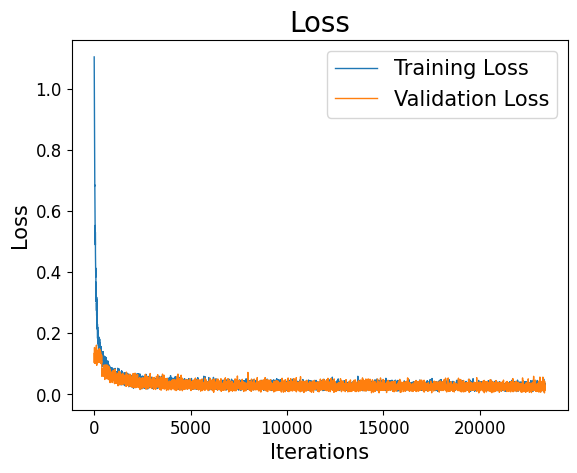

In [12]:
from matplotlib import pyplot as plt

x1 = np.linspace(0, len(losses_iteration["train"]), len(losses_iteration["train"]))
x2 = np.linspace(0, len(losses_iteration["train"]), len(losses_iteration["val"]))

plt.plot(x1, losses_iteration["train"], label="Training Loss", linewidth=1)
plt.plot(x2, losses_iteration["val"], label="Validation Loss", linewidth=1)

plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Loss", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Loss", fontsize=20)

plt.legend(loc="best", fontsize=15)

plt.show()

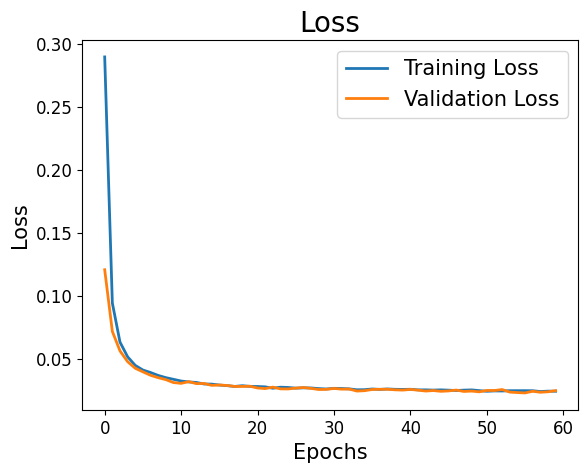

In [13]:
from matplotlib import pyplot as plt

plt.plot(losses_epoch["train"], label="Training Loss", linewidth=2)
plt.plot(losses_epoch["val"], label="Validation Loss", linewidth=2)

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("Loss", fontsize=20)

plt.legend(loc="best", fontsize=15)

plt.show()

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [14]:
def p_xt(xt, noise, t):
################################################################################
    # TODO: complete the code here
    # Write this function based on the formula given in the paper for the reverse step

    epsilon = torch.randn(xt.shape, device=xt.device)
    
    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    
    epsilon_coefficient = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    
    mean = 1 / (alpha_t ** 0.5) * (xt - epsilon_coefficient * noise)
    var = gather(beta, t)
    
    return mean + (var ** 0.5) * epsilon
    
    # End 
################################################################################


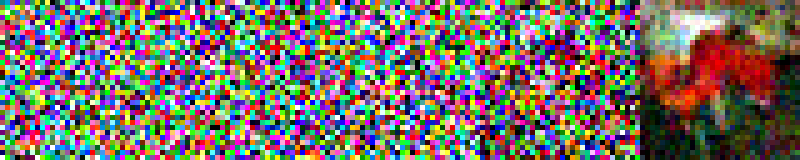

In [15]:
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []

################################################################################
    # TODO: complete the code here
    # Write the reverse step loop here

for i in range(n_steps):
    t = torch.tensor(n_steps - i - 1, dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = unet(x.float(), t.unsqueeze(0))
        
        x = p_xt(x, output, t.unsqueeze(0))
        
        if i % 240 == 0:
            ims.append(tensor_to_image(x.cpu()))

    # End 
################################################################################

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*5*5, 32*5), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

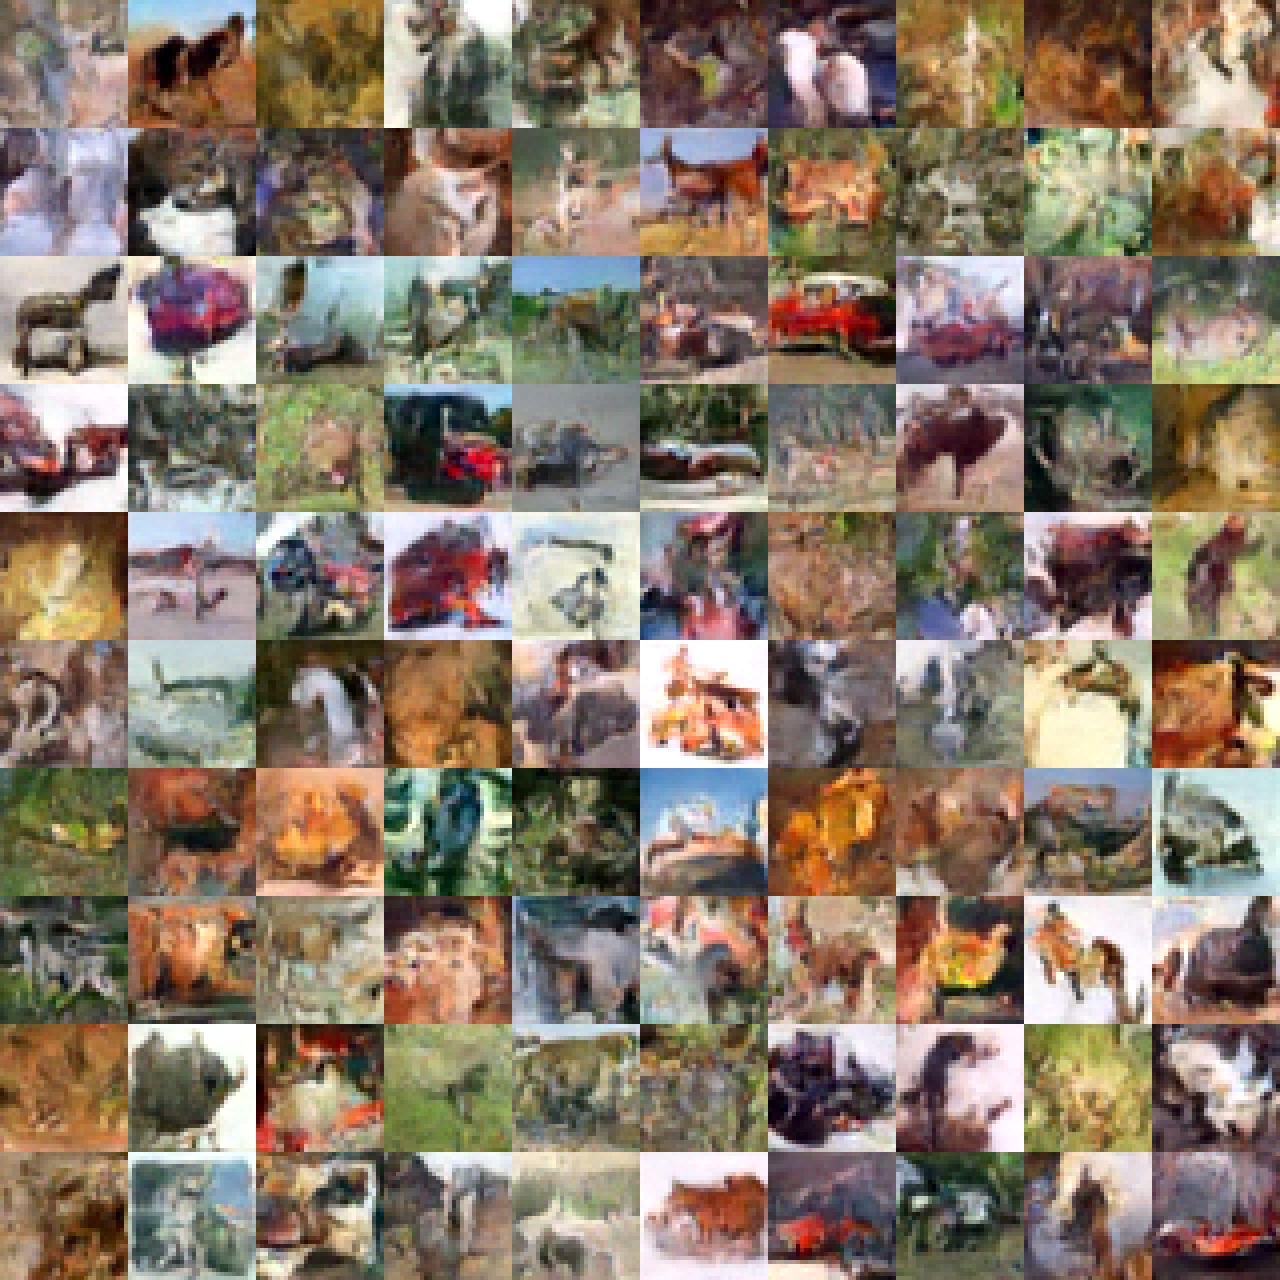

In [16]:
#@title Make and show 10 examples:
x = torch.randn(100, 3, 32, 32).cuda() # Start with random noise
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(100):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*10, 32*10))
for i, im in enumerate(ims):
  image.paste(im, ((i%10)*32, 32*(i//10)))
image.resize((32*4*10, 32*4*10), Image.NEAREST)

In [17]:
torch.save(unet.state_dict(), "final model.pt")



# **Part2: Evaluating the Generated Samples:**

Now we want to evaluate our model. For this, we use the FID score. 

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code. 

Installation

In [18]:
!pip install pytorch-fid

Generate and Save Samples

In [19]:
from torchvision.utils import save_image

# generate 3000 samples 
for k in range(3000):
    x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
    for i in range(n_steps):
        t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
        with torch.no_grad():
            pred_noise = unet(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0))
    # TODO: save the generated sample (x) in a directory
    # See this link: https://pytorch.org/vision/stable/generated/torchvision.utils.save_image.html
    # Be sure to assign a different name to each image!

    save_image(x[0], f"diffusion_generated/sample_{k}.png")

Compute the FID Score

In [20]:
# TODO: compute the FID score using pytorch-fid package.
# You should have two image directories to compute the score: 
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)

from pytorch_fid import fid_score
import random

random_idxs = random.sample(range(len(cifar10["test"])), 3000)

for k in random_idxs:
    image = cifar10["test"][k]["img"]
    
    x = img_to_tensor(image).cuda()
    
    save_image(x[0], f"diffusion_real/sample_{k}.png")

path_to_original_images = "diffusion_real/"
path_to_generated_images = "diffusion_generated/"

fid_value = fid_score.calculate_fid_given_paths([path_to_original_images, path_to_generated_images], batch_size=128, dims=2048, device=device)
print(f"FID Score: {fid_value}")

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.47it/s]


FID Score: 65.76125820744898
